# Test a multivariate input/output model

$$
\mathbf{y_d} = \mathbf{f_d} + \epsilon, \ \ \ \ \ \epsilon\sim\mathcal{N}(0,\sigma^2)
$$

where 
$$
\mathbf{f_d}\sim \mathcal{N}(\mathbf{\mu_d}, K_{dd})
$$

The differences between the univariate case is:
 - data vector is $\mathbf{y_d} = [u_1,\cdots,u_n, v_1 ,\cdots, v_n]^T$ and is $2N$ long
 - The covariance is $2N\times2N$
     $$
     K_{uv} =  \Gamma \bigotimes K
     $$
     
     where
     
     $$
     \Gamma = 
     \begin{bmatrix}
        \eta_u^2  & \eta_u \eta_v \cos \theta  \\
         \eta_u \eta_v \cos \theta & \eta_v^2
     \end{bmatrix}
     $$
     
     and
     
     $K$ is a $N\times N$  univariate covariance matrix for u **and** v i.e. they share the same parameters.

In [1]:
from oceanoi.driveroi import optimise_oi
from oceanoi.cov import cosine, expquad
from oceanoi import mean

from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def spectralmix(x, xpr, params):
    l1, T = params
    return expquad(x, xpr, l1) * cosine(x, xpr, np.sqrt(0.5*np.abs(T)))

def mycosine(x, xpr, params):
    return cosine(x, xpr, params[0])

def myexpquad(x, xpr, params):
    return expquad(x, xpr, params[0])

def zero2d(x, meanparams, **kwargs):
    x2 = np.vstack([x,x])
    return x2*0

# def linear2d(x, meanparams, **kwargs):
#     a0, bu, bv = meanparams
#     x2 = np.vstack([x,x])

In [3]:
def kernel_2d(x, xpr, params, covfunc=expquad):
    etau = params[0]
    etav = params[1]
    theta = params[2]
    otherparams = params[3:]
    Gamma = np.array([[etau*etau, etau*etav*np.cos(theta)],
                    [etau*etav*np.cos(theta), etav*etav]])

    K = covfunc(x, xpr, otherparams)

    Kuv = np.kron(Gamma, K)
    
    return Kuv

def kernel_2d_spectralmix(x, xpr, params):
    return kernel_2d(x, xpr, params, covfunc=spectralmix)

def kernel_2d_cosine(x, xpr, params):
     return kernel_2d(x, xpr, params, covfunc=mycosine)

def kernel_2d_expquad(x, xpr, params):
     return kernel_2d(x, xpr, params, covfunc=myexpquad)

In [4]:
# Switch between versions for testing
from oceanoi.oiscipy import OptimalInterpScipy as OptimalInterp
# from oceanoi.oidask import OptimalInterpDask as OptimalInterp


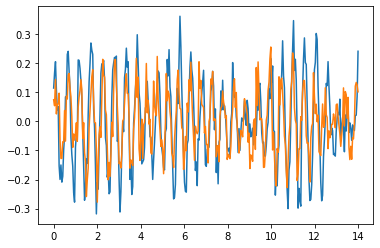

In [5]:
degrad = np.pi/180
#######
η_u = 0.3
η_v = 0.1
θ = 30*degrad
l_t = 1.5

noise=0.05

T = 12.42/24.

covfunc = kernel_2d_spectralmix
covparams = (η_u, η_v, θ, l_t, T)

# covfunc = kernel_2d_cosine
# covparams = (η_u, η_v, θ, np.sqrt(T))

# covfunc = kernel_2d_expquad
# covparams = (η_u, η_v, θ, l_t)

T = 14 # Length of the domain
N = 14*24 # Number of data points
#####
# print(omega, twopi/12.42/24)

x = np.linspace(0, T, N)[:,None] # N x 1 matrix (not N x 0 which is numpy's default)
dx = T/N


OI = OptimalInterp(x, x, noise, covfunc, covparams, 
                        P=2,
                        mean_func=zero2d)

# This will return a dask array
yd = OI.sample_prior(1)
ud = yd[0:N,...]
vd = yd[N::,...]

plt.figure()
plt.plot(x, ud)
plt.plot(x, vd)

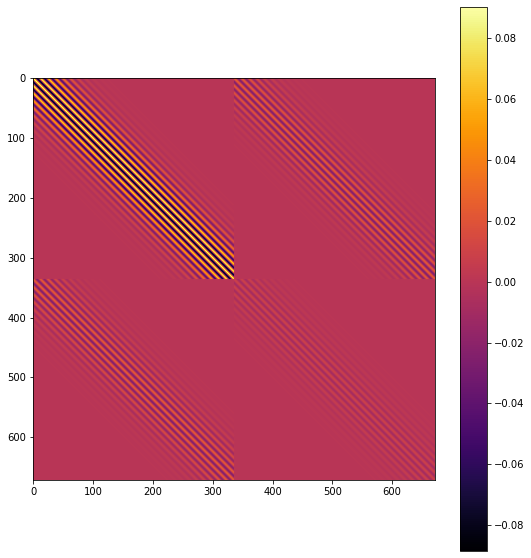

In [6]:
plt.figure(figsize=(9,10))
plt.imshow(OI.Kdd, cmap='inferno')
plt.colorbar()

In [7]:
OI.log_marg_likelihood(yd)

999.5137923461557

In [8]:
# Test parameter estimation
covparams_ic = (0.2, 0.1, 12.*degrad, 3, np.sqrt(12.42/24.))
# covparams_ic = (0.5, 0.1, 60.*degrad, 4)

noise_ic = 0.01

soln=optimise_oi(
    x, yd, 
    covfunc, covparams_ic,
    None, (),
    noise_ic,
    OIclass=OptimalInterp,
    oi_kwargs={'P':2},
    verbose=False,
    method='Powell',

)

print('Noise (real, estimated) = ({}, {})'.format(noise, soln['x'][0]))
print('Covparams (real, estimated) = ', covparams, soln['x'][1:6])
# print('meanparams (real, estimated) = ', meanparams, soln['x'][3:])

Noise (real, estimated) = (0.05, 0.04823935134930797)
Covparams (real, estimated) =  (0.3, 0.1, 0.5235987755982988, 1.5, 0.5175) [0.14072947 0.08494677 0.64835782 1.37951491 0.5227736 ]
